In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install TA-lib
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py39hd257fcd_4.tar.bz2'#!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/talib --strip-components=3
!pip install numpy==1.23.2

--2024-12-04 20:27:31--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-12-04 20:27:31--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-12-04 20:27:31--  http://phoenixnap.dl.

# The following snippet was used to train model separately

In [ ]:
model = Sequential([
    LSTM(32, return_sequences=True,activation='tanh', input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False,activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(5, activation='linear')  # Output layer
])

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
# Learning rate reduction callback
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                  patience=10,   # Number of epochs with no improvement
                                  verbose=1,    # Print messages when the learning rate is reduced
                                  factor=0.5,   # Reduce the learning rate by a factor of 0.5
                                  min_lr=1e-7)  # Minimum learning rate value


early_stopping = EarlyStopping(monitor='val_loss',
                               patience=40,  # Number of epochs with no improvement
                               verbose=1,    # Print messages when training is stopped early
                               restore_best_weights=True)

model.compile(optimizer='adam', loss='mae')

# Train the Model
history = model.fit(X_train, y_train, batch_size=64, epochs=50,verbose=1, validation_split=0.25)

# Save the Model
model.save('lstm_model_tan.keras')

In [ ]:
import talib
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
# import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import load_model
import seaborn as sns

In [ ]:
def load_and_prepare_data(csv_path, features, target):
    # Load CSV
    data = pd.read_csv(csv_path)

    # Calculate correlation matrix and visualize
    corr_matrix = data[features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix of Features')
    plt.show()

    # Extract features and target
    X_data = data[features]
    y_data = data[target]
    return data, X_data, y_data

In [ ]:
def normalize_data(X_data, y_data):
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler_X.fit_transform(X_data)
    y_scaled = scaler_y.fit_transform(y_data.values.reshape(-1, 1))
    return X_scaled, y_scaled, scaler_X, scaler_y

In [ ]:
def create_sequences(X, y, seq_length=48, target_steps=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length - target_steps + 1):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length:i + seq_length + target_steps].flatten())
    return np.array(X_seq), np.array(y_seq)

In [ ]:
def split_data(X_seq, y_seq, train_size=0.8):
    split_index = int(train_size * len(X_seq))
    X_train, X_test = X_seq[:split_index], X_seq[split_index:]
    y_train, y_test = y_seq[:split_index], y_seq[split_index:]
    return X_train, X_test, y_train, y_test

In [ ]:
def evaluate_model(model, X_test, y_test, scaler_y):
    test_loss = model.evaluate(X_test, y_test)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(-1, 5)
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).reshape(-1, 5)

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual[:, 4], label='Actual Prices')
    plt.plot(y_pred[:, 4], label='Predicted Prices')
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    return y_pred, y_test_actual

In [102]:
def backtest_strategy(data, y_pred, seq_length, atr_threshold, initial_investment=1000000, transaction_cost=0.0001,
    slippage_pct=0.001, rsi_period=37, stop_loss_pct=1):

    # Initialize variables
    cash = initial_investment
    position = 0
    results = []
    close_prices = data['Close'].values
    dates = data.index
    number_of_trades = 0
    latest_peak = None
    ignore_trading = 0
    ignore_momemtum = 0

    # Ensure `y_pred` has the correct length
    if len(y_pred) + seq_length > len(close_prices):
        raise ValueError("Predictions length is incompatible with data length and sequence length.")

    # RSI calculation
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(rsi_period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(rsi_period).mean()
    rsi = 100 - (100 / (1 + gain / loss))

    # Rolling volatility calculation
    rolling_volatility = data['Close'].pct_change().rolling(window=20).std()

    # Backtesting loop
    for i in range(len(y_pred)):
        if i + seq_length >= len(close_prices):
            break

        price_pred = y_pred[i]
        predicted_increase = (price_pred[4] - close_prices[i + seq_length]) / close_prices[i + seq_length]
        close_price = close_prices[i + seq_length]

        current_atr = data['ATR'].iloc[i + seq_length]

        # Determine if volatility is high based on ATR threshold
        high_volatility = current_atr > atr_threshold
        #high_volatility =0

        # Apply slippage to execution price
        buy_price = close_price * (1 + slippage_pct )
        sell_price = close_price * (1 - slippage_pct )

        # Update latest peak for stop-loss
        if position > 0:
            if latest_peak is None or close_price > latest_peak:
                latest_peak = close_price

        # Stop-loss logic
        if position > 0 and latest_peak is not None and close_price < latest_peak * (1 - stop_loss_pct):
            cash += position * sell_price * (1 - transaction_cost)  # Use slippage-adjusted sell price
            position = 0
            latest_peak = None
            ignore_trading = 21
            number_of_trades += 1

        # Dynamic thresholds
        buy_threshold = 0.30 * rolling_volatility.mean()
        sell_threshold = -0.75 * rolling_volatility.mean()

        # RSI signal and trading logic
        rsi_signal = rsi.iloc[i + seq_length]
        if high_volatility and ignore_momemtum == 0 and ignore_trading==0:
            sma_10 = data['SMA_20'].iloc[i + seq_length]
            sma_140 = data['SMA_140'].iloc[i + seq_length]
            if sma_10 > sma_140 and position == 0:
                # and not (any(p < close_price * 0.9 for p in predicted_prices)):
                btc_to_buy = cash / (buy_price * (1 + transaction_cost))  # Use slippage-adjusted buy price
                cash -= btc_to_buy * buy_price * (1 + transaction_cost)
                position += btc_to_buy
                number_of_trades += 1
                # print(cash)
                # latest_peak = close_price  # Record entry price for stop-loss
                # momentum_buy_signals.append((test_data.index[i + seq_length], close_price))
                # number_of_trades[0]=number_of_trades[0]+1
                # print("position1:",position,units_to_buy)
            elif (sma_10 < sma_140 and position > 0) or (predicted_increase <= sell_threshold*3 and position > 0):
                # or (any(p < close_price * 0.95 for p in predicted_prices) and position > 0):
                # or (predicted_increase < -0.02 and position > 0):
                cash += position * sell_price * (1 - transaction_cost)  # Use slippage-adjusted sell price
                position = 0
                number_of_trades += 1
                # momentum_sell_signals.append((test_data.index[i + seq_length], close_price))  # Record sell signal
                # latest_peak = None
                # number_of_trades[0]=number_of_trades[0]+1
                ignore_momemtum = 21
        elif not np.isnan(rsi_signal):
            if ((predicted_increase >= buy_threshold and position == 0) or rsi_signal < rsi.mean() - 15) and ignore_trading == 0:
                btc_to_buy = cash / (buy_price * (1 + transaction_cost))  # Use slippage-adjusted buy price
                cash -= btc_to_buy * buy_price * (1 + transaction_cost)
                position += btc_to_buy
                number_of_trades += 1
                # print(cash)
            elif predicted_increase <= sell_threshold and position > 0 and rsi_signal > rsi.mean() + 15:
                cash += position * sell_price * (1 - transaction_cost)  # Use slippage-adjusted sell price
                position = 0
                number_of_trades += 1

        if ignore_trading > 0:
            ignore_trading -= 1
        if ignore_momemtum > 0:
            ignore_momemtum -= 1

        # Record portfolio value
        portfolio_value = cash + (position * close_price)
        results.append({
            'Date': dates[i + seq_length],
            'Cash': cash,
            'Position': position,
            'Portfolio Value': portfolio_value,
            'Close Price': close_price
        })

    # Ensure results are not empty
    if not results:
        raise ValueError("No trades were executed. Ensure your strategy logic is valid.")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Calculate returns and performance metrics
    results_df['returns'] = results_df['Portfolio Value'].pct_change()
    downside_returns = results_df['returns'][results_df['returns'] < 0]
    downside_deviation = downside_returns.std() if not downside_returns.empty else 0
    mean_return = results_df['returns'].mean()
    std_return = results_df['returns'].std()

    sharpe_ratio = ((mean_return * 8760) - 0.04) / (std_return * (8760 ** 0.5))
    sortino_ratio = ((mean_return * 8760) - 0.04) / (downside_deviation * (8760 ** 0.5))

    # Performance metrics
    initial_portfolio_value = initial_investment
    final_portfolio_value = results_df['Portfolio Value'].iloc[-1]
    total_return = (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value * 100
    max_drawdown = ((results_df['Portfolio Value'].cummax() - results_df['Portfolio Value']).max() / results_df['Portfolio Value'].cummax().max()) * 100

    # Performance Report
    print("Performance Report:")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Number of Trades: {number_of_trades}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Sortino Ratio: {sortino_ratio:.2f}")

    # Step 1: Define Initial and Final Prices
    initial_opening_price = data['Open'].iloc[0]
    final_closing_price = data['Close'].iloc[-1]

    # Step 2: Calculate Total Return
    total_return = (final_closing_price - initial_opening_price) / initial_opening_price


    # Step 4: Daily Returns for Volatility and Downside Deviation
    hourly_returns_bh = data['Close'].pct_change().dropna()

    downside_returns = hourly_returns_bh[hourly_returns_bh < 0]
    downside_deviation_bh = downside_returns.std() if not downside_returns.empty else 0
    mean_return_bh = hourly_returns_bh.mean()
    std_return_bh = hourly_returns_bh.std()
    # Step 5: Risk-Free Rate
    risk_free_rate = 0.04  # Example: 4% annual risk-free rate

    # Step 6: Sharpe Ratio
    sharpe_ratio_bh = ((mean_return_bh * 8760) - 0.04) / (std_return_bh * (8760 ** 0.5))
    sortino_ratio_bh = ((mean_return_bh * 8760) - 0.04) / (downside_deviation_bh * (8760 ** 0.5))


    # Output Results
    print("\nResults Buy and Hold:")
    print(f"Total Return: {total_return * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio_bh:.2f}")
    print(f"Sortino Ratio: {sortino_ratio_bh:.2f}")

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Date'], results_df['Portfolio Value'], label='Strategy Portfolio Value', color='green')
    plt.plot(data.index, data['Close'], label='Close Price', color='blue')
    plt.title('Portfolio Value and Close Price Over Time')
    plt.xlabel('Trading Hour Index')
    plt.ylabel('Portfolio Value / Close Price')
    plt.legend()
    plt.grid()
    plt.show()

    # Compare Portfolio Value Over Time vs Buy and Hold
    buy_and_hold_value = initial_investment * (data['Close'] / data['Close'].iloc[0])

    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Date'], results_df['Portfolio Value'], label='Strategy Portfolio Value', color='green')
    plt.plot(data.index, buy_and_hold_value, label='Buy and Hold', color='purple')
    plt.title('Portfolio Value Over Time vs Buy and Hold')
    plt.xlabel('Trading Hour Index')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid()
    plt.show()

    return results_df


In [105]:
def main(csv_path):
    """
    Processes a single asset, runs backtesting, and returns results.
    """
    features = ['Close', 'Volume', 'Volatility', 'SMA_10', 'RSI', 'MACD', 'Middle_BB', 'ATR', 'OBV']
    target = 'Close'

    model_path = 'lstm_model_tan.keras'

    # Load and prepare data
    data, X_data, y_data = load_and_prepare_data(csv_path, features, target)
    X_scaled, y_scaled, scaler_X, scaler_y = normalize_data(X_data, y_data)
    seq_length = 48
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length=seq_length)
    X_train, X_test, y_train, y_test = split_data(X_seq, y_seq)

    # Load model and predict
    model = load_model(model_path)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(-1, 5)

    # Define ATR threshold dynamically using historical volatility
    historical_atr = data['ATR']  # Use ATR values from the historical dataset
    atr_mean = historical_atr.mean()
    atr_std_dev = historical_atr.std()

    if csv_path == "BTC_TALIB.csv":
      atr_threshold = atr_mean + 2 * atr_std_dev
    else:
      atr_threshold = atr_mean + atr_std_dev


    data['SMA_20'] = talib.SMA(data['Close'], timeperiod=20)

    # Backtest the strategy
    results_df = backtest_strategy(data.iloc[len(X_train):], y_pred, seq_length, atr_threshold)
    return results_df


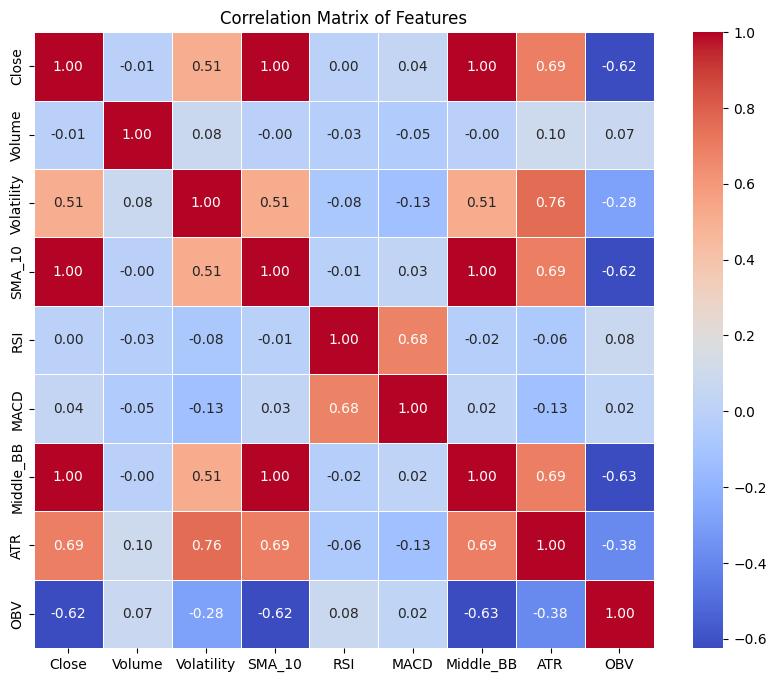

255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Performance Report:
Total Return: 196.82%
Final Portfolio Value: $2968240.94
Maximum Drawdown: 26.76%
Number of Trades: 850
Sharpe Ratio: 2.59
Sortino Ratio: 3.32

Results Buy and Hold:
Total Return: 123.90%
Sharpe Ratio: 1.88
Sortino Ratio: 2.42


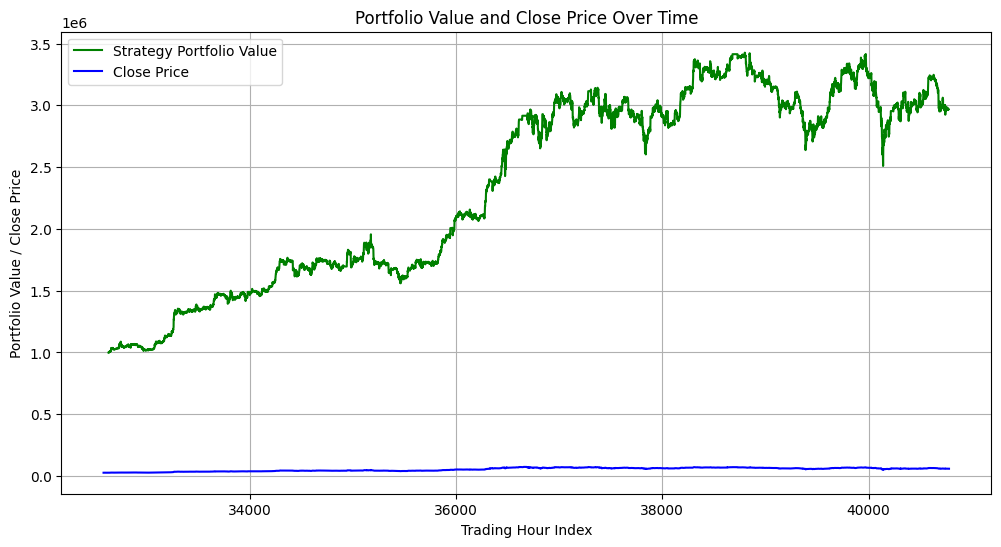

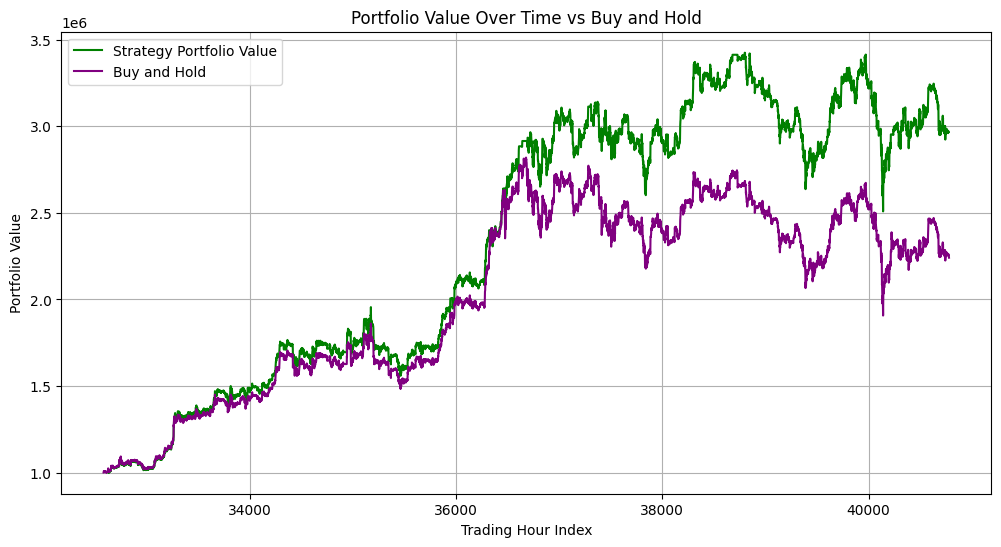

Date          Cash   Position  Portfolio Value  Close Price   returns
0     32630  1.164153e-10  38.194513     9.989011e+05        26153       NaN
1     32631  1.164153e-10  38.194513     1.002682e+06        26252  0.003785
2     32632  1.164153e-10  38.194513     1.000734e+06        26201 -0.001943
3     32633  1.164153e-10  38.194513     9.999706e+05        26181 -0.000763
4     32634  1.164153e-10  38.194513     1.000811e+06        26203  0.000840
...     ...           ...        ...              ...          ...       ...
8141  40771  0.000000e+00  50.361237     2.960989e+06        58795 -0.001070
8142  40772  0.000000e+00  50.361237     2.965673e+06        58888  0.001582
8143  40773  0.000000e+00  50.361237     2.972522e+06        59024  0.002309
8144  40774  0.000000e+00  50.361237     2.970809e+06        58990 -0.000576
8145  40775  0.000000e+00  50.361237     2.968241e+06        58939 -0.000865

[8146 rows x 6 columns]

In [106]:
# Run the pipeline with your CSV
csv_path = 'BTC_TALIB.csv'
main(csv_path)

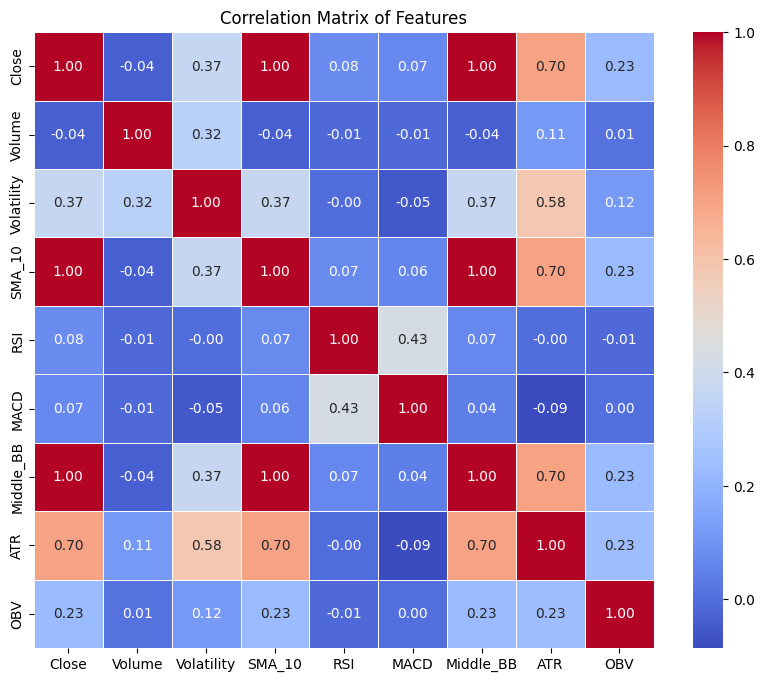

255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Performance Report:
Total Return: 131.13%
Final Portfolio Value: $2311302.94
Maximum Drawdown: 36.18%
Number of Trades: 1757
Sharpe Ratio: 1.71
Sortino Ratio: 0.93

Results Buy and Hold:
Total Return: 118.27%
Sharpe Ratio: 1.57
Sortino Ratio: 0.87


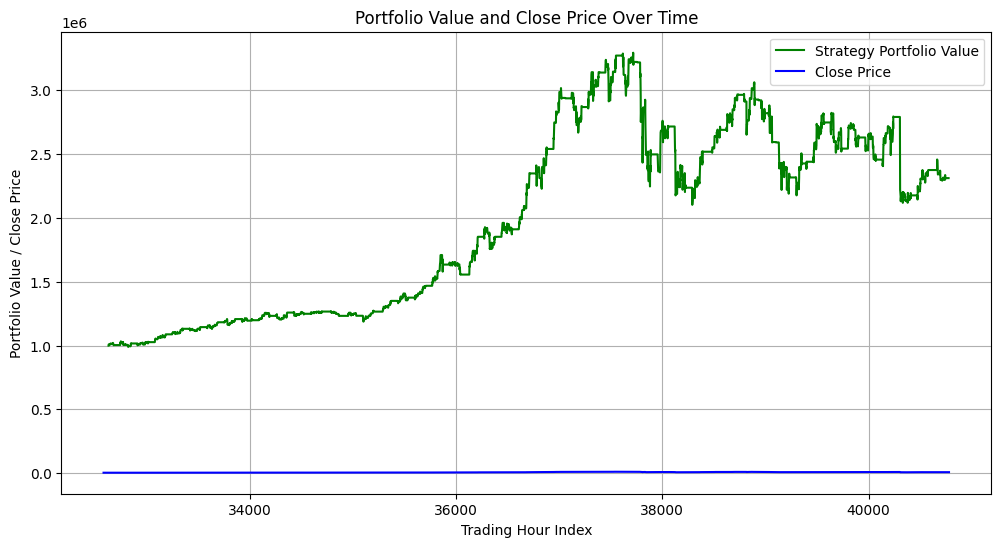

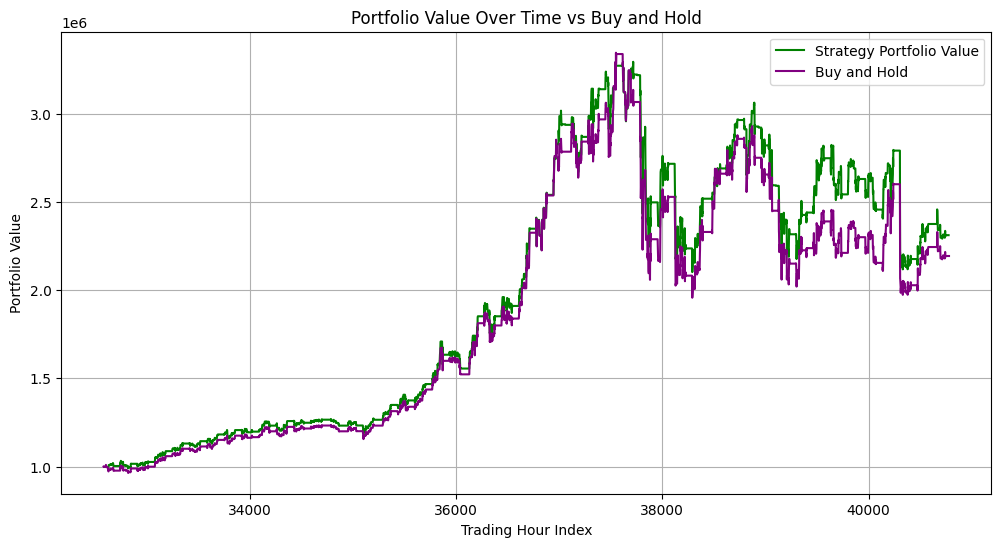

Date          Cash    Position  Portfolio Value  Close Price   returns
0     32630 -1.164153e-10  293.486542     9.989011e+05     3403.567       NaN
1     32631  0.000000e+00  293.486542     1.008733e+06     3437.067  0.009843
2     32632  0.000000e+00  293.486542     1.009200e+06     3438.657  0.000463
3     32633  0.000000e+00  293.486542     1.008733e+06     3437.067 -0.000462
4     32634  0.000000e+00  293.486542     1.008733e+06     3437.067  0.000000
...     ...           ...         ...              ...          ...       ...
8141  40771  0.000000e+00  301.204613     2.311303e+06     7673.531  0.000000
8142  40772  0.000000e+00  301.204613     2.311303e+06     7673.531  0.000000
8143  40773  0.000000e+00  301.204613     2.311303e+06     7673.531  0.000000
8144  40774  0.000000e+00  301.204613     2.311303e+06     7673.531  0.000000
8145  40775  0.000000e+00  301.204613     2.311303e+06     7673.531  0.000000

[8146 rows x 6 columns]

In [89]:
# Run the pipeline with your CSV
csv_path = '/content/COCOA_TALIB.csv'
main(csv_path)

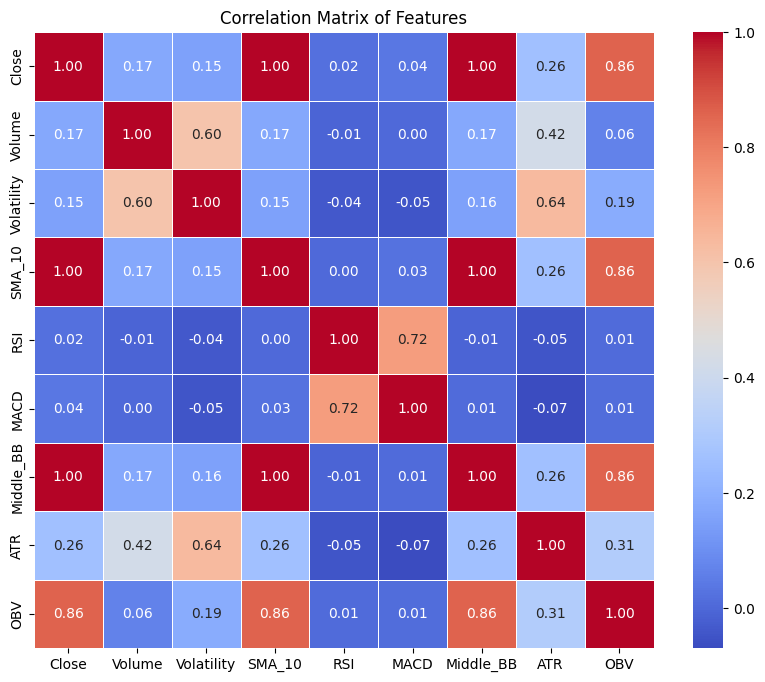

255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Performance Report:
Total Return: -1.74%
Final Portfolio Value: $982572.82
Maximum Drawdown: 19.04%
Number of Trades: 1352
Sharpe Ratio: -0.23
Sortino Ratio: -0.25

Results Buy and Hold:
Total Return: 14.76%
Sharpe Ratio: 0.66
Sortino Ratio: 0.75


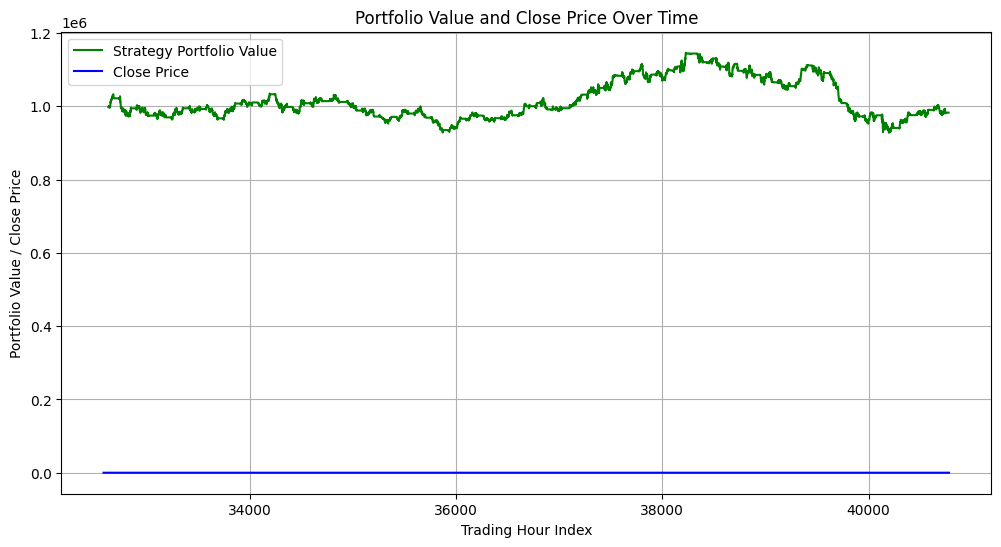

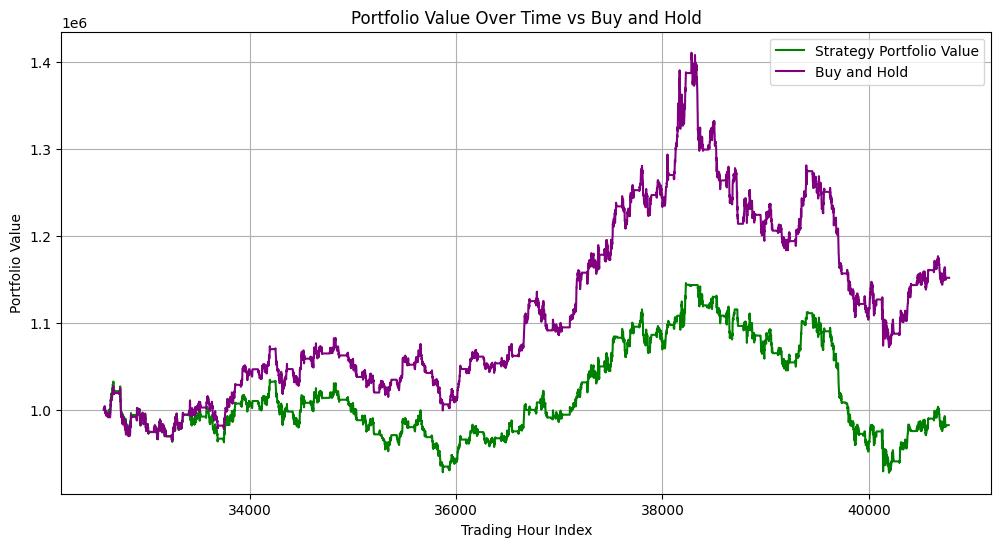

Date  Cash       Position  Portfolio Value  Close Price   returns
0     32630   0.0  274544.060271     9.989011e+05       3.6384       NaN
1     32631   0.0  274544.060271     1.000219e+06       3.6432  0.001319
2     32632   0.0  274544.060271     9.979677e+05       3.6350 -0.002251
3     32633   0.0  274544.060271     9.965675e+05       3.6299 -0.001403
4     32634   0.0  274544.060271     9.991207e+05       3.6392  0.002562
...     ...   ...            ...              ...          ...       ...
8141  40771   0.0  232975.178968     9.825728e+05       4.2175  0.000000
8142  40772   0.0  232975.178968     9.825728e+05       4.2175  0.000000
8143  40773   0.0  232975.178968     9.825728e+05       4.2175  0.000000
8144  40774   0.0  232975.178968     9.825728e+05       4.2175  0.000000
8145  40775   0.0  232975.178968     9.825728e+05       4.2175  0.000000

[8146 rows x 6 columns]

In [90]:
# Run the pipeline with your CSV
csv_path = '/content/COPPER_TALIB.csv'
main(csv_path)

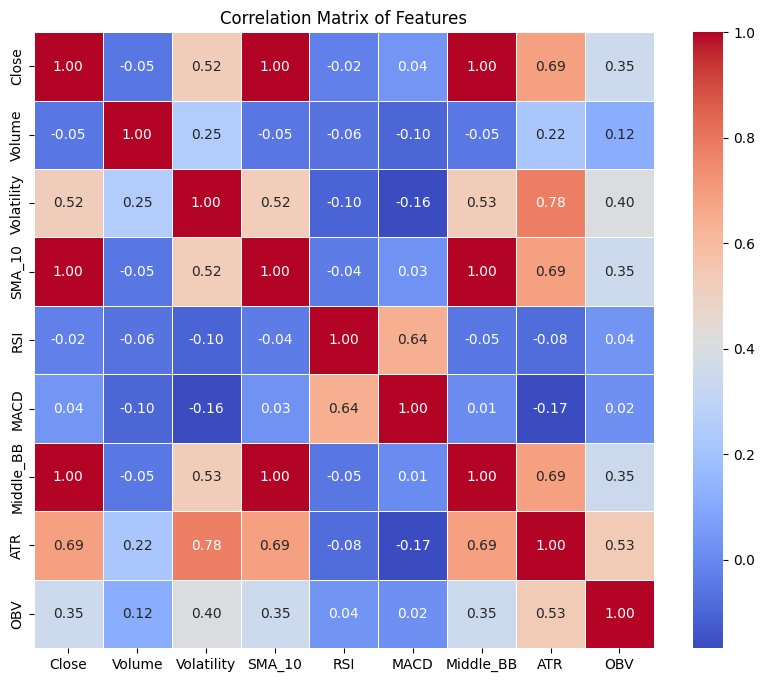

255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Performance Report:
Total Return: 44.33%
Final Portfolio Value: $1443305.07
Maximum Drawdown: 44.75%
Number of Trades: 866
Sharpe Ratio: 0.91
Sortino Ratio: 1.12

Results Buy and Hold:
Total Return: 58.11%
Sharpe Ratio: 1.05
Sortino Ratio: 1.32


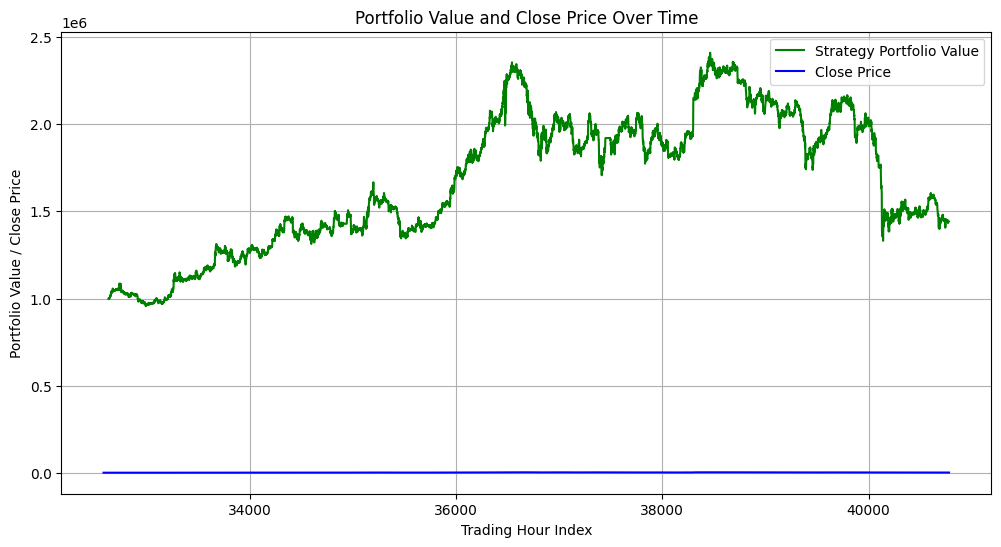

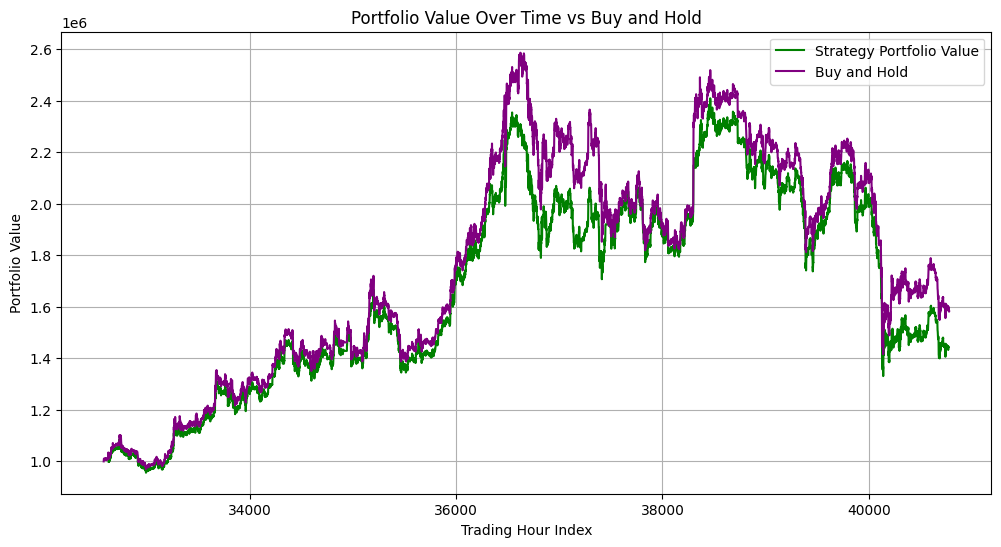

Date          Cash    Position  Portfolio Value  Close Price   returns
0     32630 -1.164153e-10  627.844820     9.989011e+05         1591       NaN
1     32631 -1.164153e-10  627.844820     1.002668e+06         1597  0.003771
2     32632 -1.164153e-10  627.844820     1.001412e+06         1595 -0.001252
3     32633 -1.164153e-10  627.844820     1.000157e+06         1593 -0.001254
4     32634 -1.164153e-10  627.844820     9.989011e+05         1591 -0.001255
...     ...           ...         ...              ...          ...       ...
8141  40771  0.000000e+00  574.792938     1.434683e+06         2496  0.001605
8142  40772  0.000000e+00  574.792938     1.438707e+06         2503  0.002804
8143  40773  0.000000e+00  574.792938     1.445604e+06         2515  0.004794
8144  40774  0.000000e+00  574.792938     1.445029e+06         2514 -0.000398
8145  40775  0.000000e+00  574.792938     1.443305e+06         2511 -0.001193

[8146 rows x 6 columns]

In [104]:
# Run the pipeline with your CSV
csv_path = '/content/ETH_TALIB.csv'
main(csv_path)

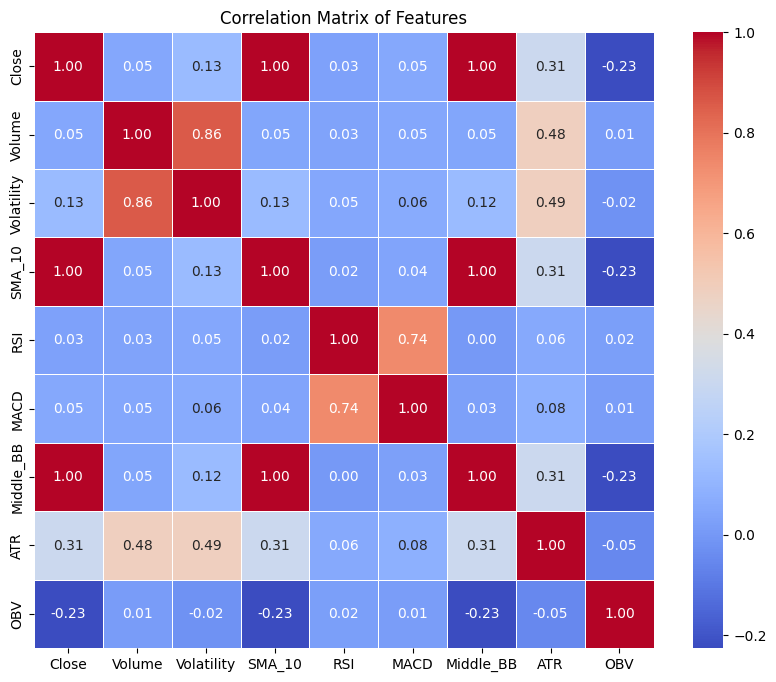

255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Performance Report:
Total Return: 23.42%
Final Portfolio Value: $1234241.53
Maximum Drawdown: 19.62%
Number of Trades: 1700
Sharpe Ratio: 0.75
Sortino Ratio: 0.57

Results Buy and Hold:
Total Return: 60.78%
Sharpe Ratio: 1.56
Sortino Ratio: 1.24


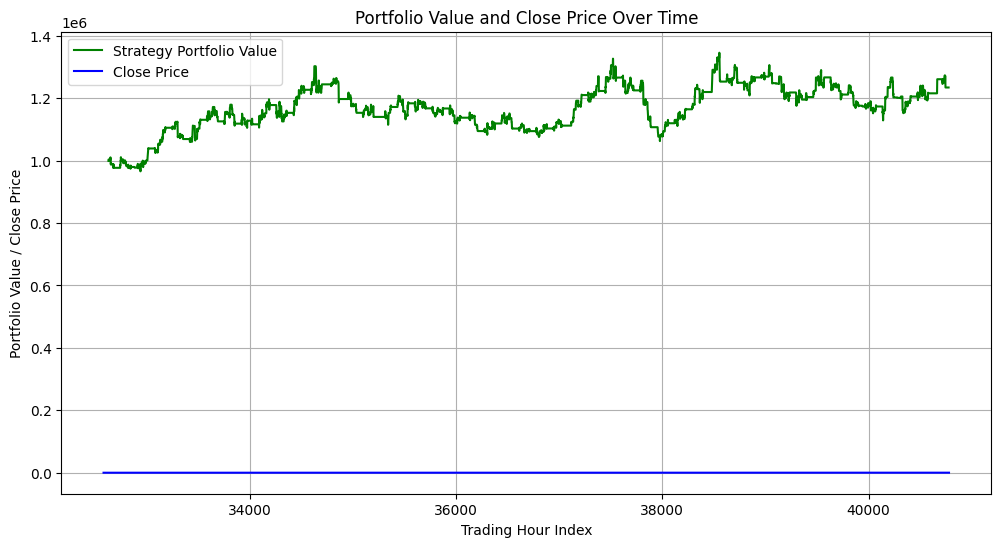

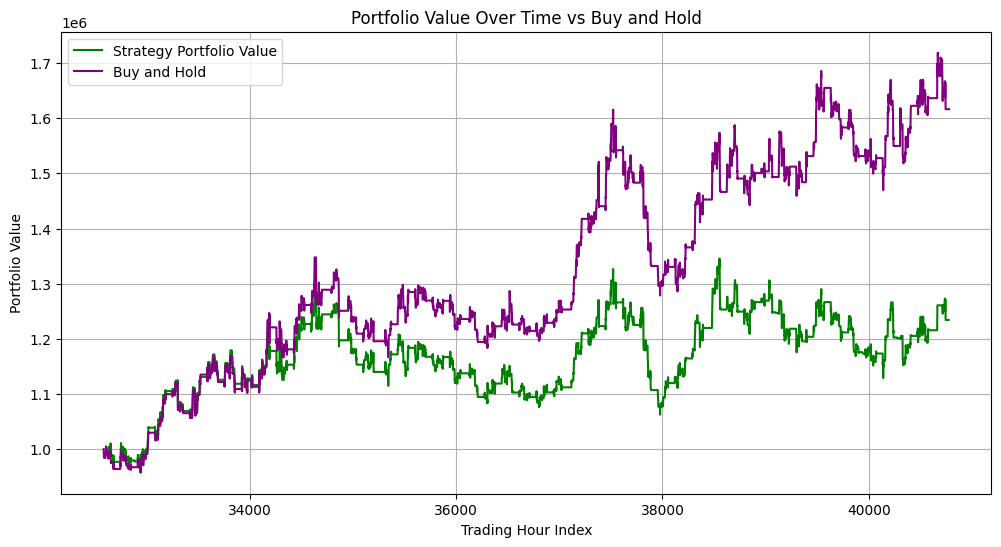

Date  Cash     Position  Portfolio Value  Close Price   returns
0     32630   0.0  6737.450232     9.989011e+05      148.261       NaN
1     32631   0.0  6737.450232     1.003786e+06      148.986  0.004890
2     32632   0.0  6737.450232     1.002782e+06      148.837 -0.001000
3     32633   0.0  6737.450232     1.000828e+06      148.547 -0.001948
4     32634   0.0  6737.450232     1.000828e+06      148.547  0.000000
...     ...   ...          ...              ...          ...       ...
8141  40771   0.0  5075.903773     1.234242e+06      243.157  0.000000
8142  40772   0.0  5075.903773     1.234242e+06      243.157  0.000000
8143  40773   0.0  5075.903773     1.234242e+06      243.157  0.000000
8144  40774   0.0  5075.903773     1.234242e+06      243.157  0.000000
8145  40775   0.0  5075.903773     1.234242e+06      243.157  0.000000

[8146 rows x 6 columns]

In [92]:
# Run the pipeline with your CSV
csv_path = '/content/COFFEE_TALIB.csv'
main(csv_path)

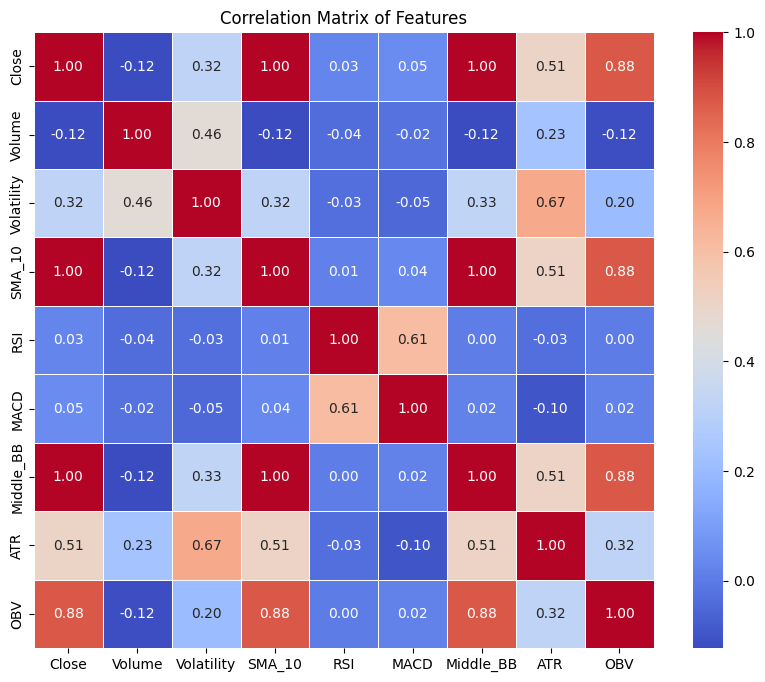

255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Performance Report:
Total Return: -30.76%
Final Portfolio Value: $692441.09
Maximum Drawdown: 34.48%
Number of Trades: 1291
Sharpe Ratio: -1.28
Sortino Ratio: -1.26

Results Buy and Hold:
Total Return: -28.03%
Sharpe Ratio: -1.12
Sortino Ratio: -1.10


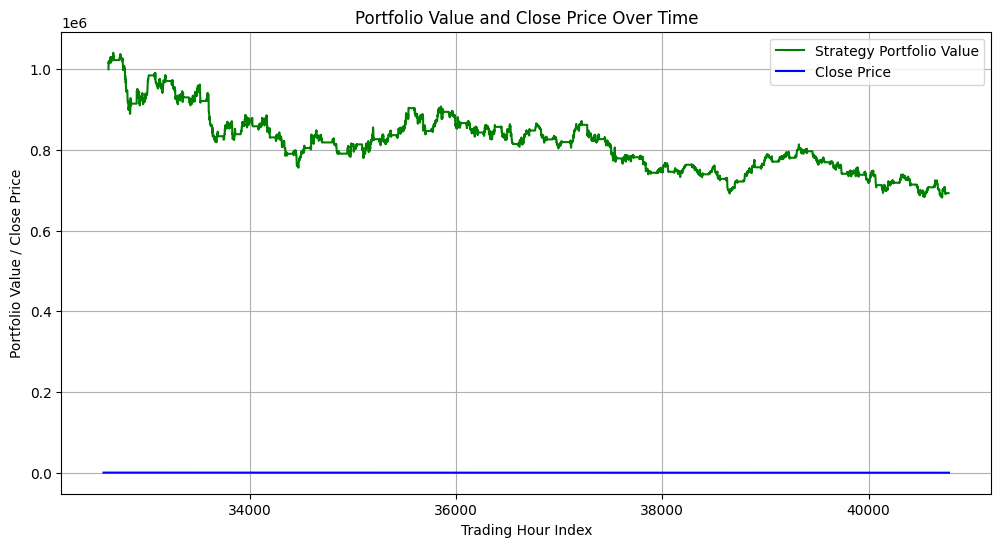

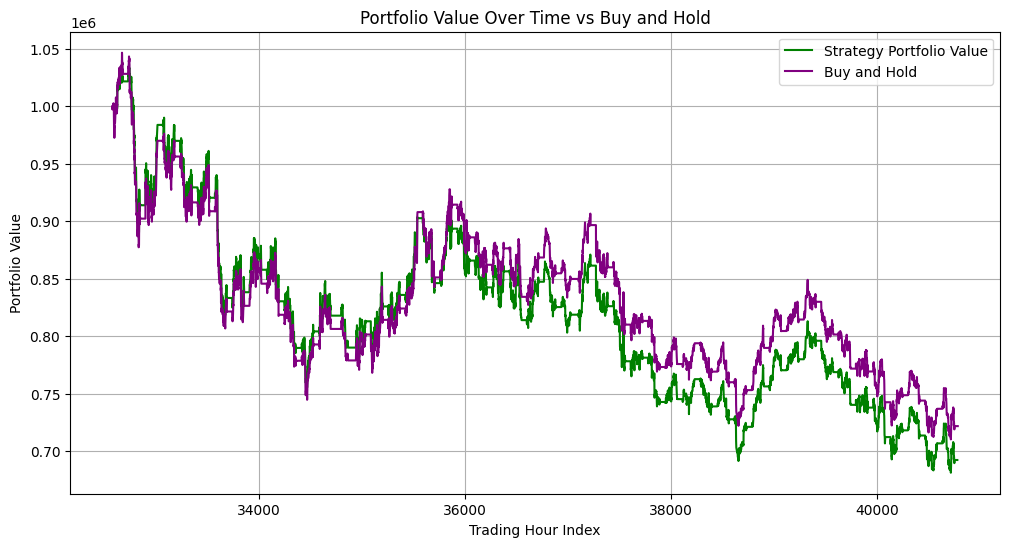

Date  Cash     Position  Portfolio Value  Close Price   returns
0     32630   0.0  1036.141055     9.989011e+05      964.059       NaN
1     32631   0.0  1036.141055     1.015973e+06      980.535  0.017090
2     32632   0.0  1036.141055     1.013525e+06      978.173 -0.002409
3     32633   0.0  1036.141055     1.019087e+06      983.541  0.005488
4     32634   0.0  1036.141055     1.018700e+06      983.167 -0.000380
...     ...   ...          ...              ...          ...       ...
8141  40771   0.0   995.746457     6.924411e+05      695.399  0.000000
8142  40772   0.0   995.746457     6.924411e+05      695.399  0.000000
8143  40773   0.0   995.746457     6.924411e+05      695.399  0.000000
8144  40774   0.0   995.746457     6.924411e+05      695.399  0.000000
8145  40775   0.0   995.746457     6.924411e+05      695.399  0.000000

[8146 rows x 6 columns]

In [93]:
# Run the pipeline with your CSV
csv_path = '/content/DIESEL_TALIB.csv'
main(csv_path)

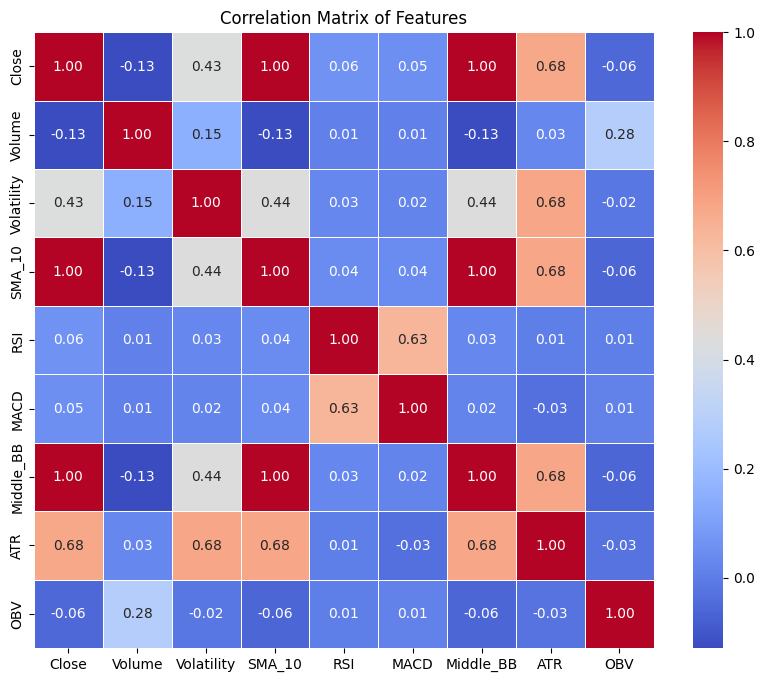

255/255 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Performance Report:
Total Return: -28.86%
Final Portfolio Value: $711378.47
Maximum Drawdown: 54.03%
Number of Trades: 1493
Sharpe Ratio: -0.42
Sortino Ratio: -0.45

Results Buy and Hold:
Total Return: -26.46%
Sharpe Ratio: -0.23
Sortino Ratio: -0.26


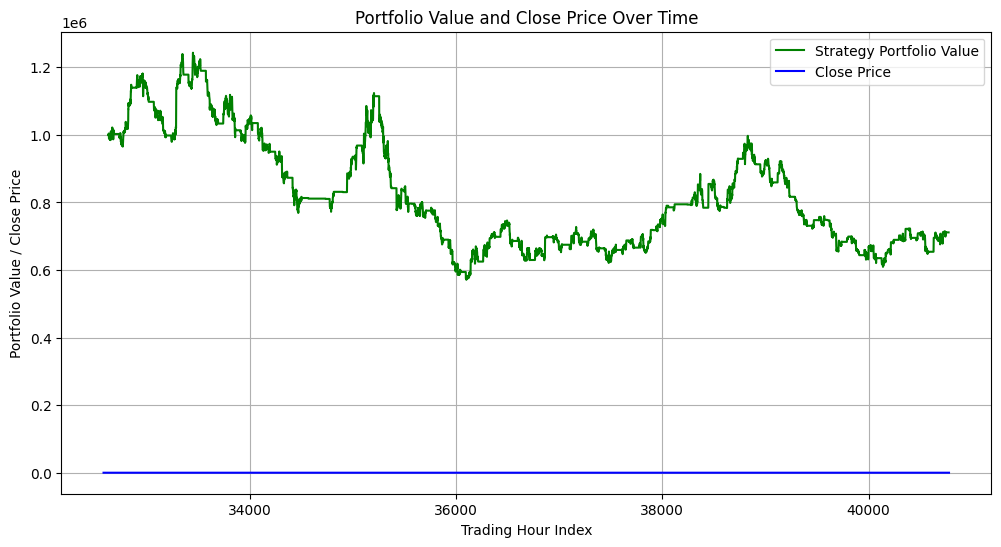

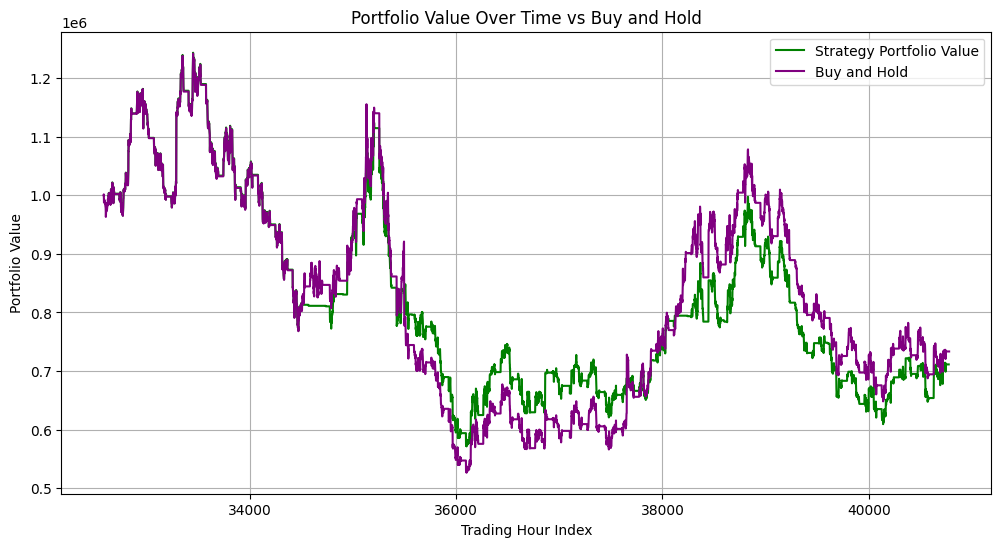

Date          Cash       Position  Portfolio Value  Close Price  \
0     32630  1.164153e-10  342782.028376     9.989011e+05       2.9141   
1     32631  1.164153e-10  342782.028376     9.979070e+05       2.9112   
2     32632  1.164153e-10  342782.028376     1.004009e+06       2.9290   
3     32633  1.164153e-10  342782.028376     1.000204e+06       2.9179   
4     32634  1.164153e-10  342782.028376     9.920797e+05       2.8942   
...     ...           ...            ...              ...          ...   
8141  40771  0.000000e+00  332311.148216     7.113785e+05       2.1407   
8142  40772  0.000000e+00  332311.148216     7.113785e+05       2.1407   
8143  40773  0.000000e+00  332311.148216     7.113785e+05       2.1407   
8144  40774  0.000000e+00  332311.148216     7.113785e+05       2.1407   
8145  40775  0.000000e+00  332311.148216     7.113785e+05       2.1407   

       returns  
0          NaN  
1    -0.000995  
2     0.006114  
3    -0.003790  
4    -0.008122  
...        ...  
8141  0.000000  
8142  0.000000  
8143  0.000000  
8144  0.000000  
8145  0.000000  

[8146 rows x 6 columns]

In [94]:
# Run the pipeline with your CSV
csv_path = '/content/GAS_TALIB.csv'
main(csv_path)

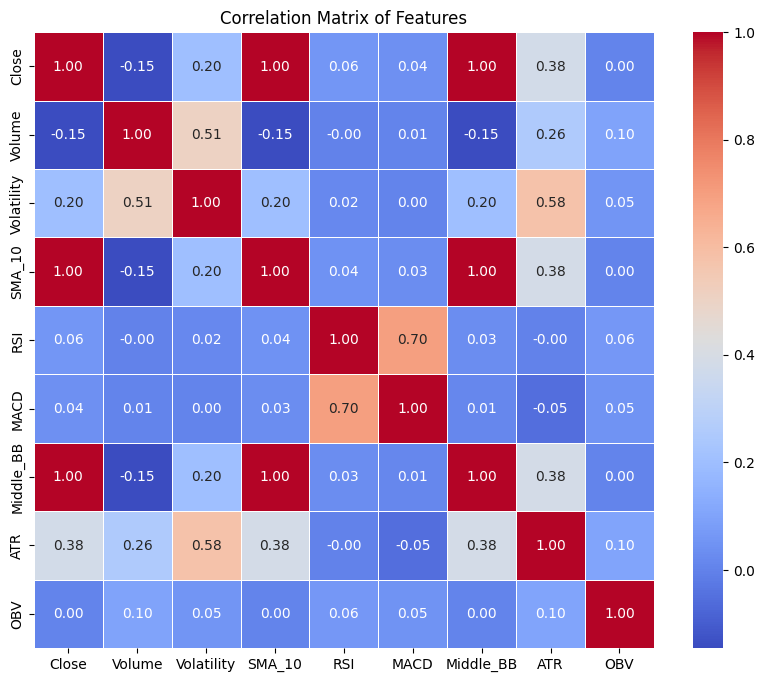

255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Performance Report:
Total Return: -28.61%
Final Portfolio Value: $713919.88
Maximum Drawdown: 36.18%
Number of Trades: 1489
Sharpe Ratio: -2.21
Sortino Ratio: -2.04

Results Buy and Hold:
Total Return: -22.55%
Sharpe Ratio: -1.66
Sortino Ratio: -1.56


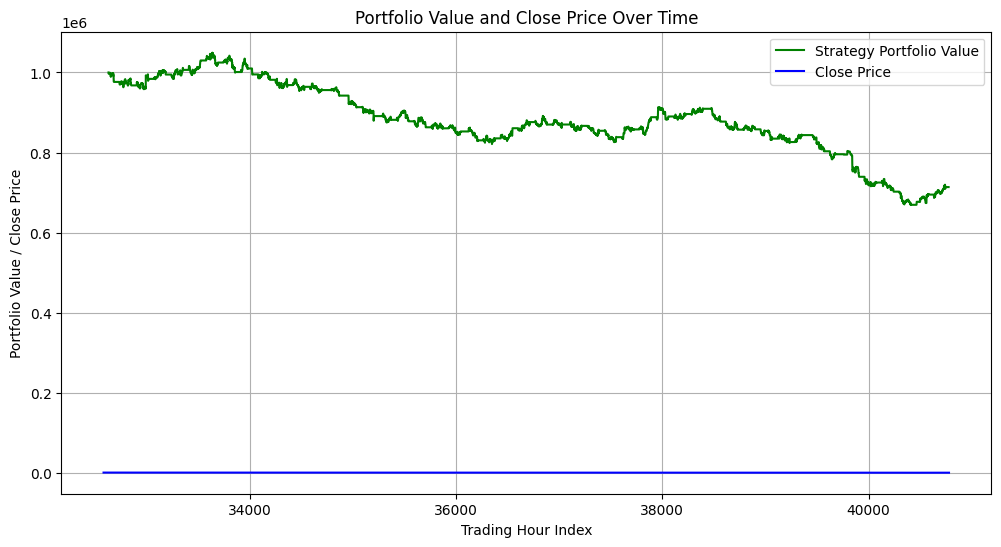

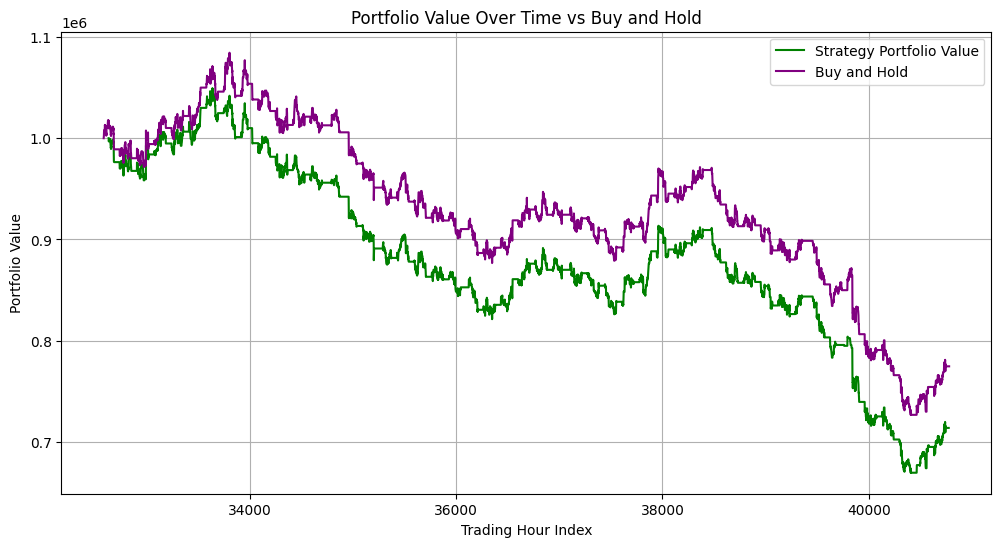

Date       Cash    Position  Portfolio Value  Close Price   returns
0     32630  1000000.0    0.000000   1000000.000000     1311.027       NaN
1     32631        0.0  766.177110    998901.108890     1303.747 -0.001099
2     32632        0.0  766.177110    996794.121837     1300.997 -0.002109
3     32633        0.0  766.177110    997958.711045     1302.517  0.001168
4     32634        0.0  766.177110    997874.431562     1302.407 -0.000084
...     ...        ...         ...              ...          ...       ...
8141  40771        0.0  715.168566    713919.881278      998.254  0.000000
8142  40772        0.0  715.168566    713919.881278      998.254  0.000000
8143  40773        0.0  715.168566    713919.881278      998.254  0.000000
8144  40774        0.0  715.168566    713919.881278      998.254  0.000000
8145  40775        0.0  715.168566    713919.881278      998.254  0.000000

[8146 rows x 6 columns]

In [95]:
# Run the pipeline with your CSV
csv_path = '/content/SOYBEAN_TALIB.csv'
main(csv_path)

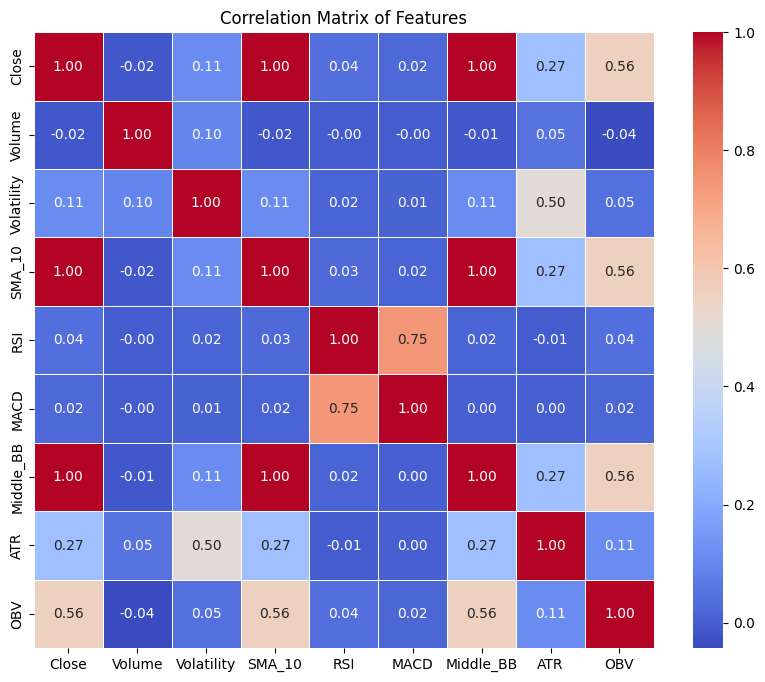

255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Performance Report:
Total Return: -37.19%
Final Portfolio Value: $628124.07
Maximum Drawdown: 44.11%
Number of Trades: 1830
Sharpe Ratio: -2.26
Sortino Ratio: -1.62

Results Buy and Hold:
Total Return: -24.37%
Sharpe Ratio: -1.23
Sortino Ratio: -0.95


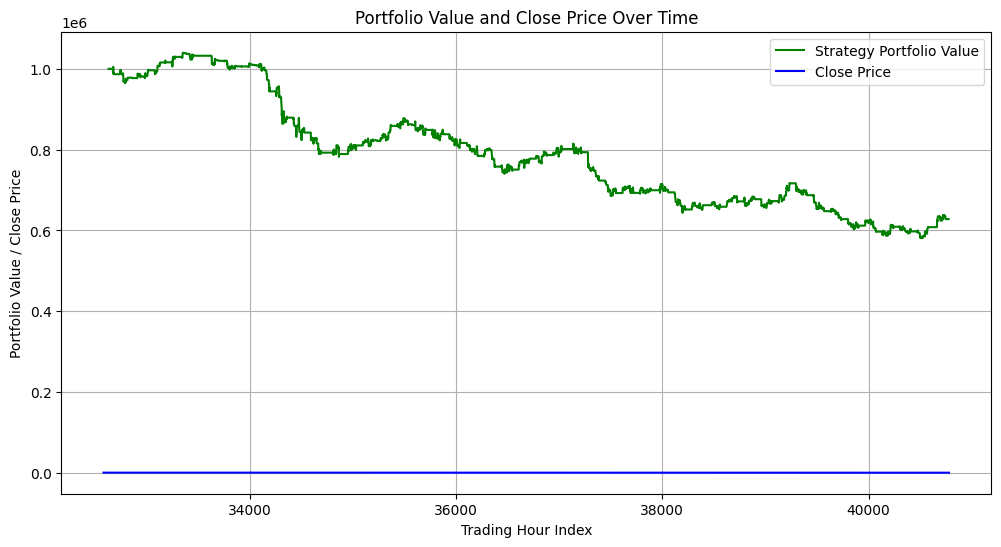

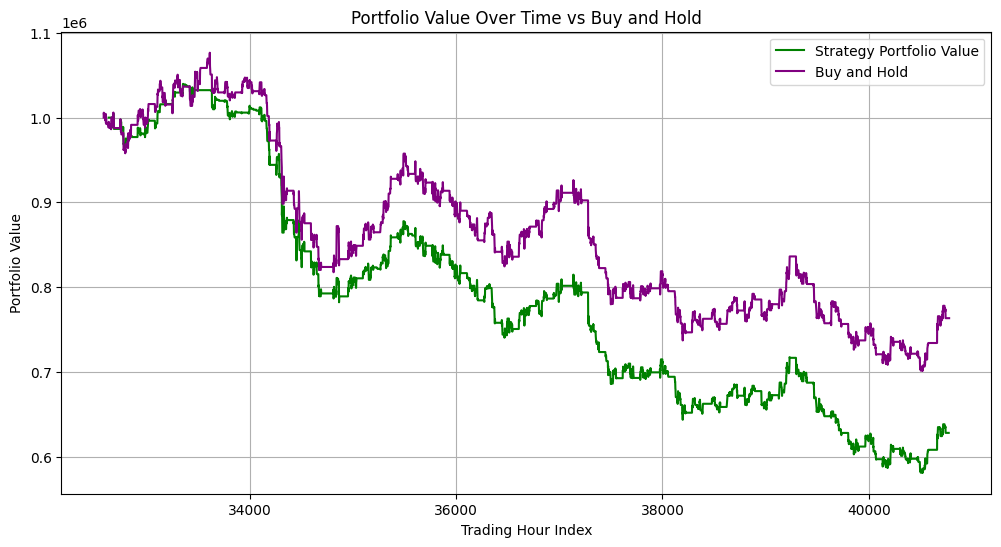

Date       Cash     Position  Portfolio Value  Close Price  returns
0     32630  1000000.0     0.000000   1000000.000000      706.972      NaN
1     32631  1000000.0     0.000000   1000000.000000      711.825      0.0
2     32632  1000000.0     0.000000   1000000.000000      708.927      0.0
3     32633  1000000.0     0.000000   1000000.000000      708.927      0.0
4     32634  1000000.0     0.000000   1000000.000000      708.927      0.0
...     ...        ...          ...              ...          ...      ...
8141  40771        0.0  1150.073367    628124.070041      546.160      0.0
8142  40772        0.0  1150.073367    628124.070041      546.160      0.0
8143  40773        0.0  1150.073367    628124.070041      546.160      0.0
8144  40774        0.0  1150.073367    628124.070041      546.160      0.0
8145  40775        0.0  1150.073367    628124.070041      546.160      0.0

[8146 rows x 6 columns]

In [96]:
# Run the pipeline with your CSV
csv_path = '/content/SUGAR_TALIB.csv'
main(csv_path)

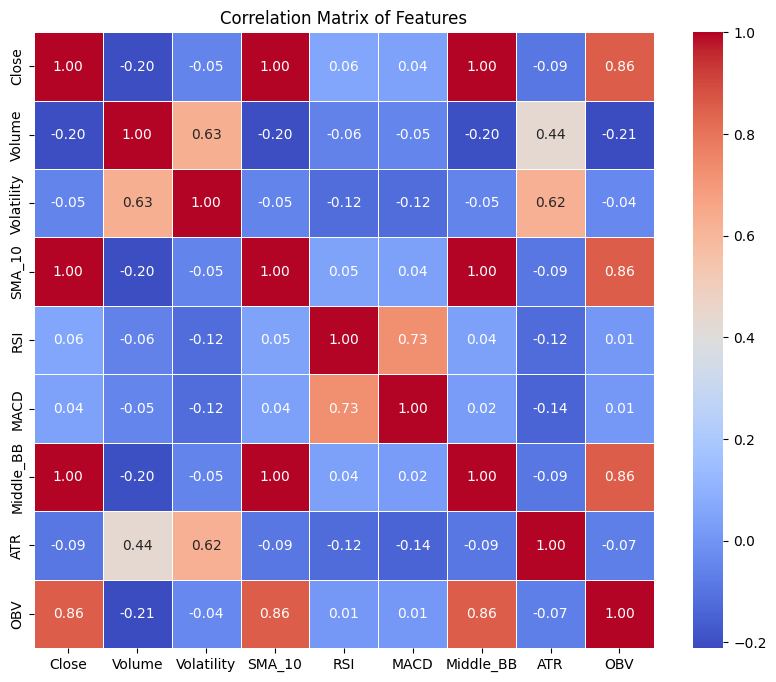

255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Performance Report:
Total Return: 2.82%
Final Portfolio Value: $1028203.89
Maximum Drawdown: 16.75%
Number of Trades: 1602
Sharpe Ratio: 0.02
Sortino Ratio: 0.02

Results Buy and Hold:
Total Return: 32.87%
Sharpe Ratio: 1.66
Sortino Ratio: 1.63


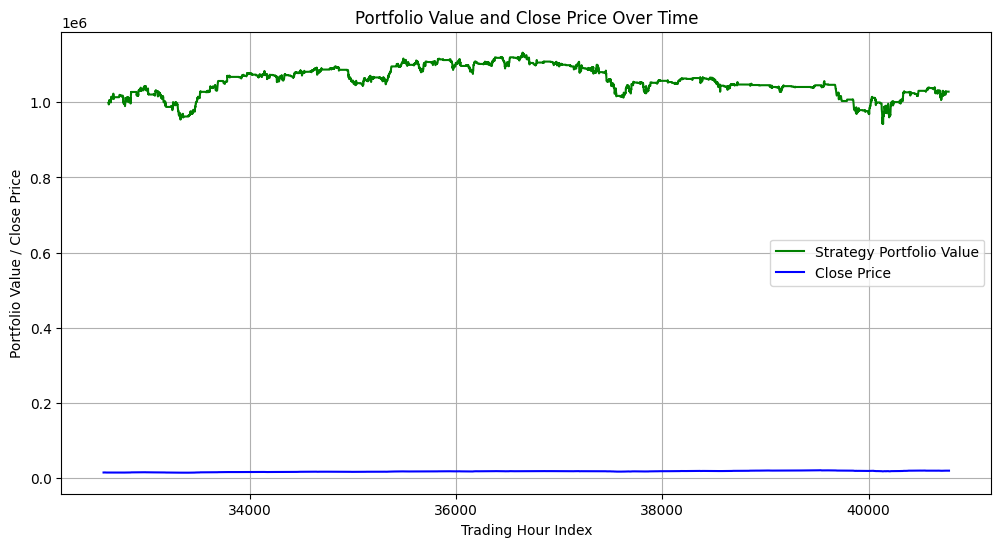

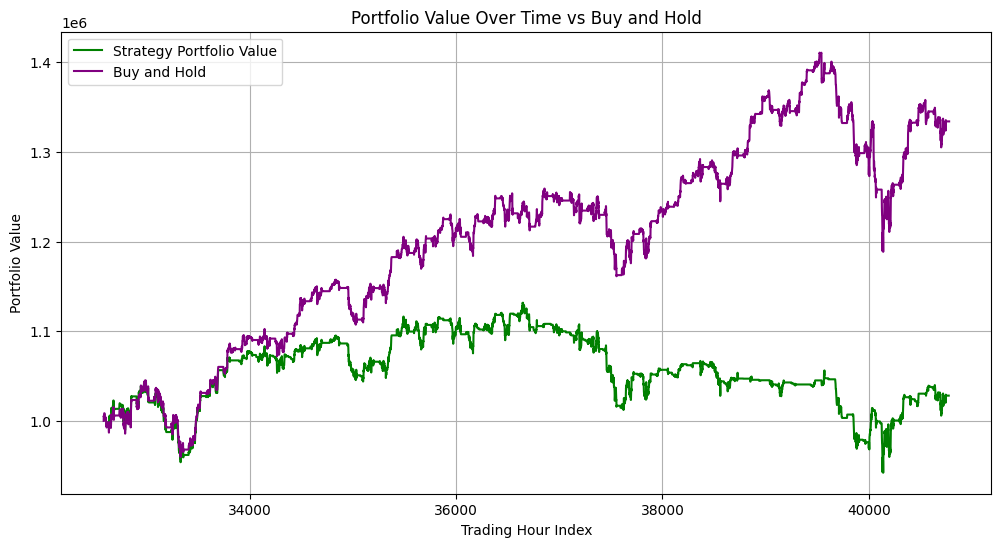

Date          Cash   Position  Portfolio Value  Close Price   returns
0     32630 -1.164153e-10  68.751238     9.989011e+05    14529.209       NaN
1     32631  0.000000e+00  68.751238     9.985278e+05    14523.779 -0.000374
2     32632  0.000000e+00  68.751238     9.967712e+05    14498.229 -0.001759
3     32633  0.000000e+00  68.751238     9.942295e+05    14461.259 -0.002550
4     32634  0.000000e+00  68.751238     1.002442e+06    14580.719  0.008261
...     ...           ...        ...              ...          ...       ...
8141  40771  0.000000e+00  52.609106     1.028204e+06    19544.219  0.000000
8142  40772  0.000000e+00  52.609106     1.028204e+06    19544.219  0.000000
8143  40773  0.000000e+00  52.609106     1.028204e+06    19544.219  0.000000
8144  40774  0.000000e+00  52.609106     1.028204e+06    19544.219  0.000000
8145  40775  0.000000e+00  52.609106     1.028204e+06    19544.219  0.000000

[8146 rows x 6 columns]

In [97]:
# Run the pipeline with your CSV
csv_path = '/content/USATECH_TALIB.csv'
main(csv_path)

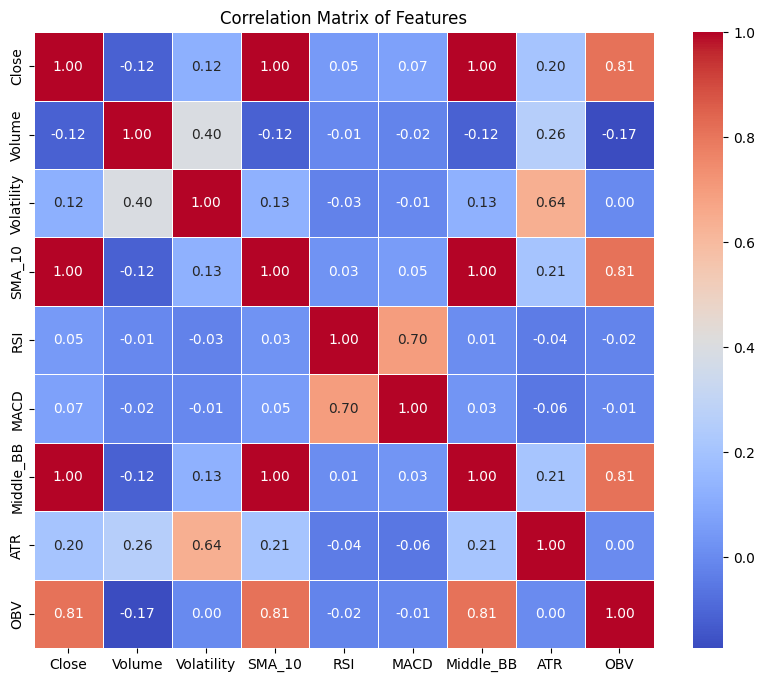

255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Performance Report:
Total Return: 22.78%
Final Portfolio Value: $1227833.18
Maximum Drawdown: 15.80%
Number of Trades: 1271
Sharpe Ratio: 0.82
Sortino Ratio: 0.85

Results Buy and Hold:
Total Return: 22.80%
Sharpe Ratio: 0.83
Sortino Ratio: 0.90


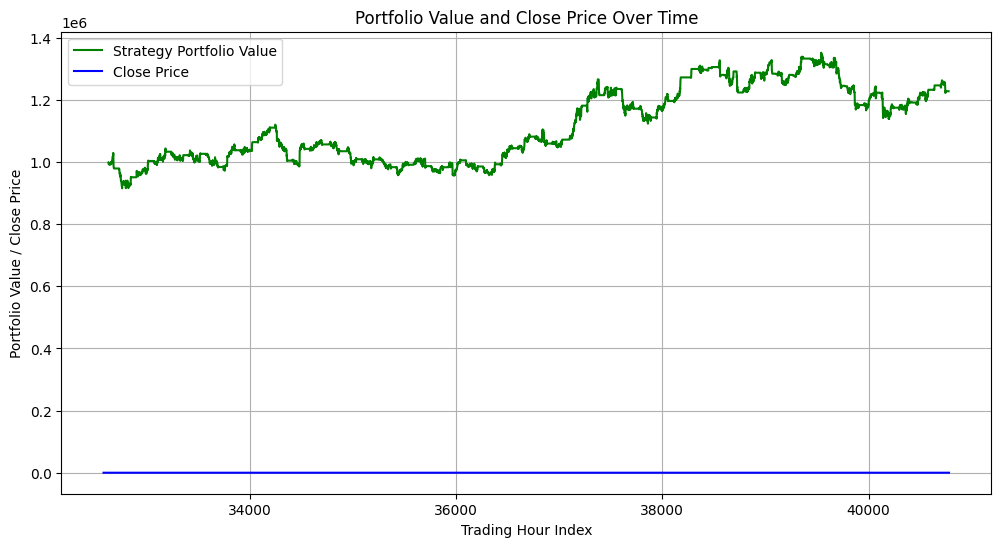

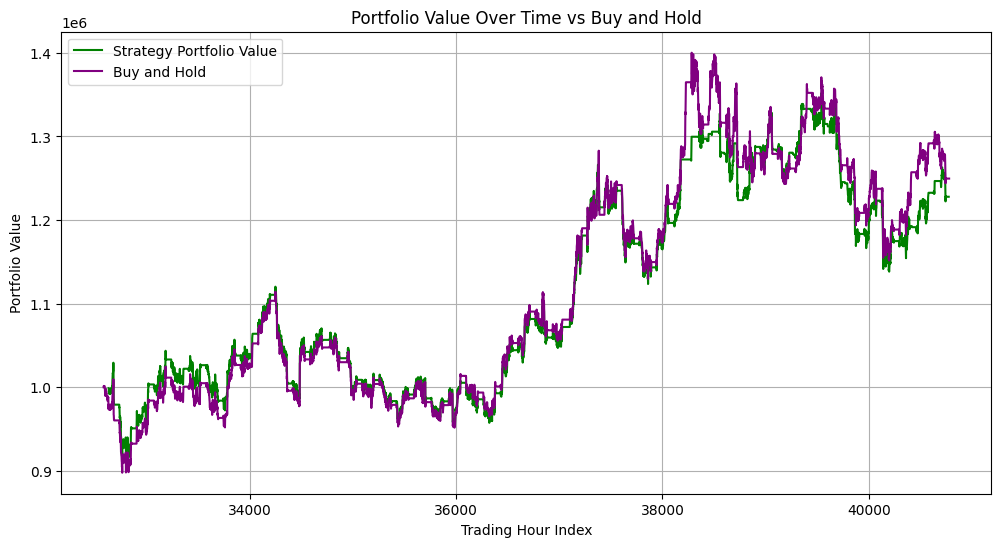

Date  Cash      Position  Portfolio Value  Close Price   returns
0     32630   0.0  44171.801048     9.989011e+05       22.614       NaN
1     32631   0.0  44171.801048     9.986361e+05       22.608 -0.000265
2     32632   0.0  44171.801048     9.945281e+05       22.515 -0.004114
3     32633   0.0  44171.801048     9.924520e+05       22.468 -0.002087
4     32634   0.0  44171.801048     9.960299e+05       22.549  0.003605
...     ...   ...           ...              ...          ...       ...
8141  40771   0.0  42568.062031     1.227833e+06       28.844  0.000000
8142  40772   0.0  42568.062031     1.227833e+06       28.844  0.000000
8143  40773   0.0  42568.062031     1.227833e+06       28.844  0.000000
8144  40774   0.0  42568.062031     1.227833e+06       28.844  0.000000
8145  40775   0.0  42568.062031     1.227833e+06       28.844  0.000000

[8146 rows x 6 columns]

In [98]:
# Run the pipeline with your CSV
csv_path = '/content/XAG_TALIB.csv'
main(csv_path)

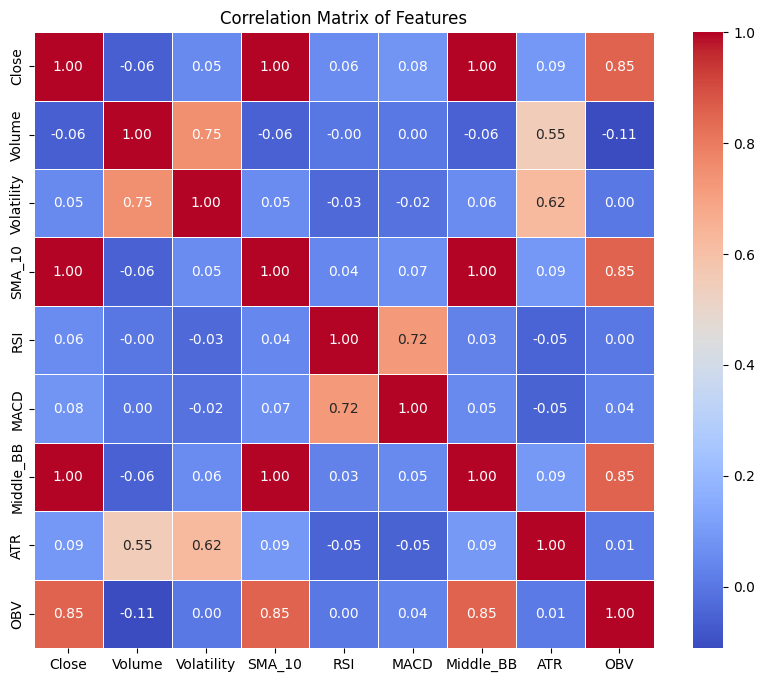

255/255 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Performance Report:
Total Return: 13.92%
Final Portfolio Value: $1139245.74
Maximum Drawdown: 10.22%
Number of Trades: 1396
Sharpe Ratio: 0.85
Sortino Ratio: 0.88

Results Buy and Hold:
Total Return: 30.01%
Sharpe Ratio: 1.83
Sortino Ratio: 1.95


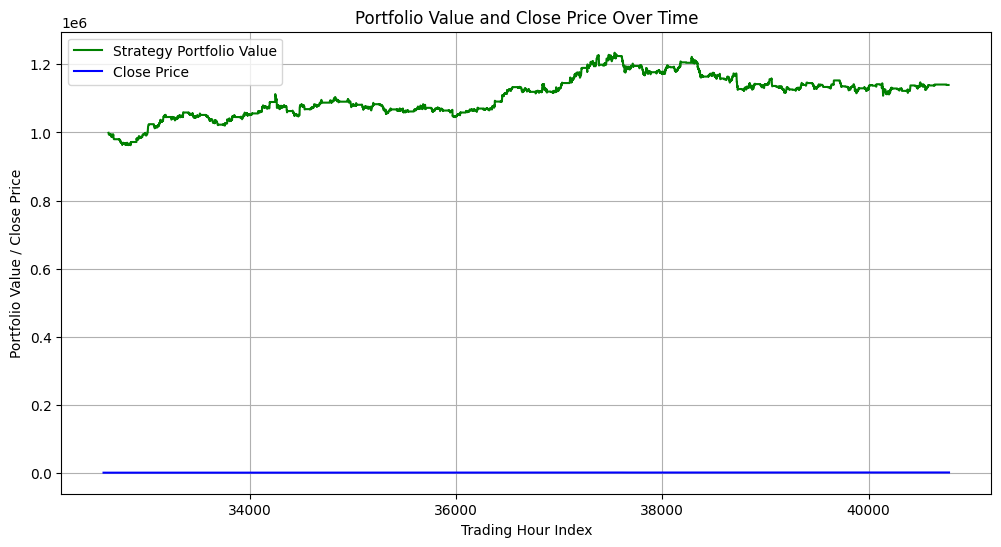

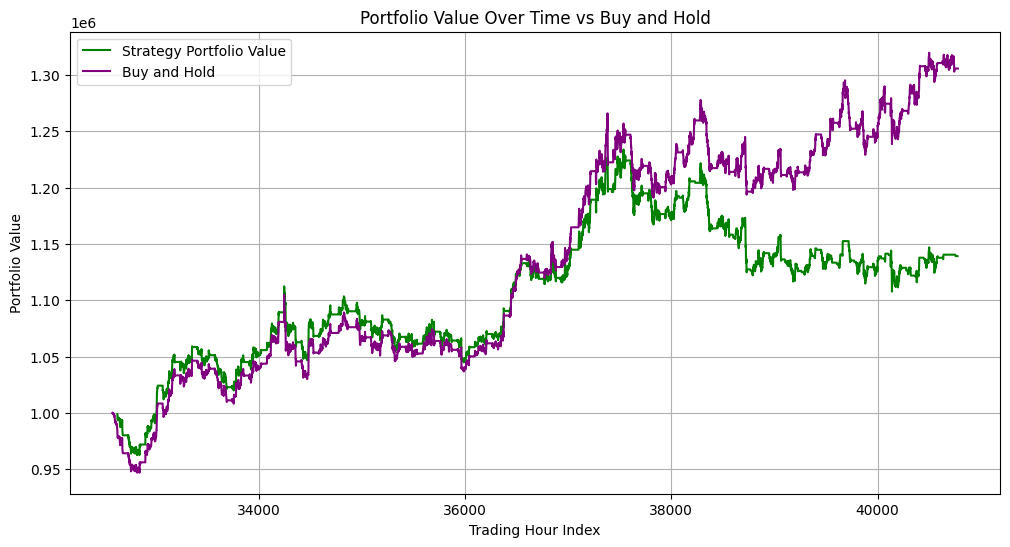

Date  Cash    Position  Portfolio Value  Close Price   returns
0     32630   0.0  530.338813     9.989011e+05     1883.515       NaN
1     32631   0.0  530.338813     9.977715e+05     1881.385 -0.001131
2     32632   0.0  530.338813     9.947963e+05     1875.775 -0.002982
3     32633   0.0  530.338813     9.941811e+05     1874.615 -0.000618
4     32634   0.0  530.338813     9.948811e+05     1875.935  0.000704
...     ...   ...         ...              ...          ...       ...
8141  40771   0.0  455.165750     1.139246e+06     2502.925  0.000000
8142  40772   0.0  455.165750     1.139246e+06     2502.925  0.000000
8143  40773   0.0  455.165750     1.139246e+06     2502.925  0.000000
8144  40774   0.0  455.165750     1.139246e+06     2502.925  0.000000
8145  40775   0.0  455.165750     1.139246e+06     2502.925  0.000000

[8146 rows x 6 columns]

In [99]:
# Run the pipeline with your CSV
csv_path = '/content/XAU_TALIB.csv'
main(csv_path)

In [100]:
def portfolio_analysis(results_dict, weights, initial_investment=1000000):
    """
    Analyze a diversified portfolio and compute metrics.
    """
    # Divide initial investment by weights
    weighted_investment = {asset: initial_investment * weight for asset, weight in weights.items()}

    # Initialize portfolio value
    portfolio_value = None

    for asset, weight in weights.items():
        asset_results = results_dict.get(asset)
        if asset_results is None:
            print(f"Skipping asset {asset} due to missing data.")
            continue

        # Scale individual portfolio value based on allocated investment
        asset_results['Weighted Value'] = asset_results['Portfolio Value'] / asset_results['Portfolio Value'].iloc[0] * weighted_investment[asset]

        # Combine into total portfolio value
        if portfolio_value is None:
            portfolio_value = asset_results['Weighted Value']
        else:
            portfolio_value += asset_results['Weighted Value']

    if portfolio_value is None:
        raise ValueError("No valid data available for portfolio analysis.")

    # Create a consolidated portfolio DataFrame
    portfolio = pd.DataFrame({'Portfolio Value': portfolio_value})
    portfolio['returns'] = portfolio['Portfolio Value'].pct_change()

    # Calculate portfolio performance metrics
    total_return = (portfolio['Portfolio Value'].iloc[-1] / portfolio['Portfolio Value'].iloc[0] - 1) * 100
    mean_return = portfolio['returns'].mean()
    std_return = portfolio['returns'].std()
    sharpe_ratio = (mean_return / std_return) * np.sqrt(252) if std_return > 0 else 0

    # Display performance metrics
    print(f"Portfolio Total Return: {total_return:.2f}%")
    print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.2f}")

    # Visualize portfolio performance
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio.index, portfolio['Portfolio Value'], label='Portfolio Value')
    plt.title('Diversified Portfolio Performance')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid()
    plt.show()

    return portfolio

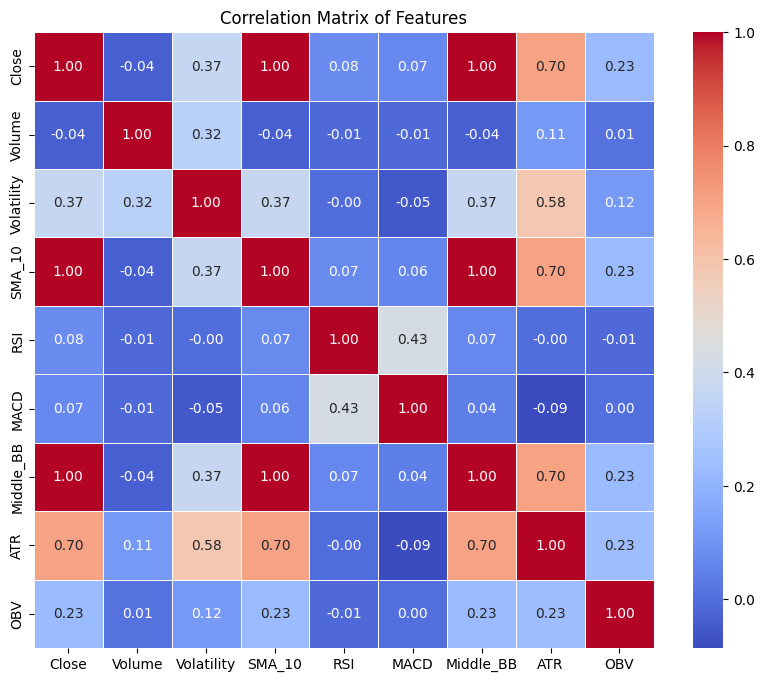

255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Performance Report:
Total Return: 131.13%
Final Portfolio Value: $2311302.94
Maximum Drawdown: 36.18%
Number of Trades: 1757
Sharpe Ratio: 1.71
Sortino Ratio: 0.93

Results Buy and Hold:
Total Return: 118.27%
Sharpe Ratio: 1.57
Sortino Ratio: 0.87


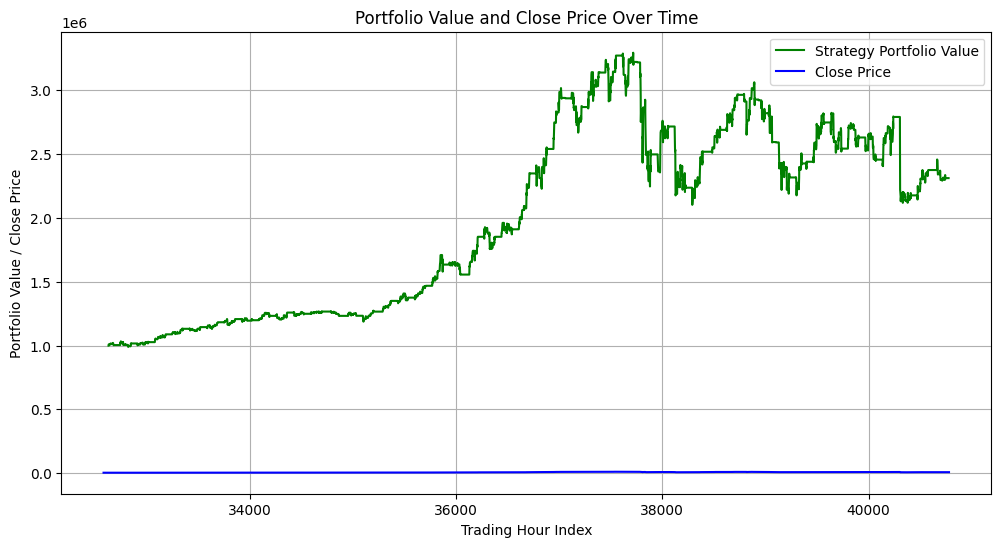

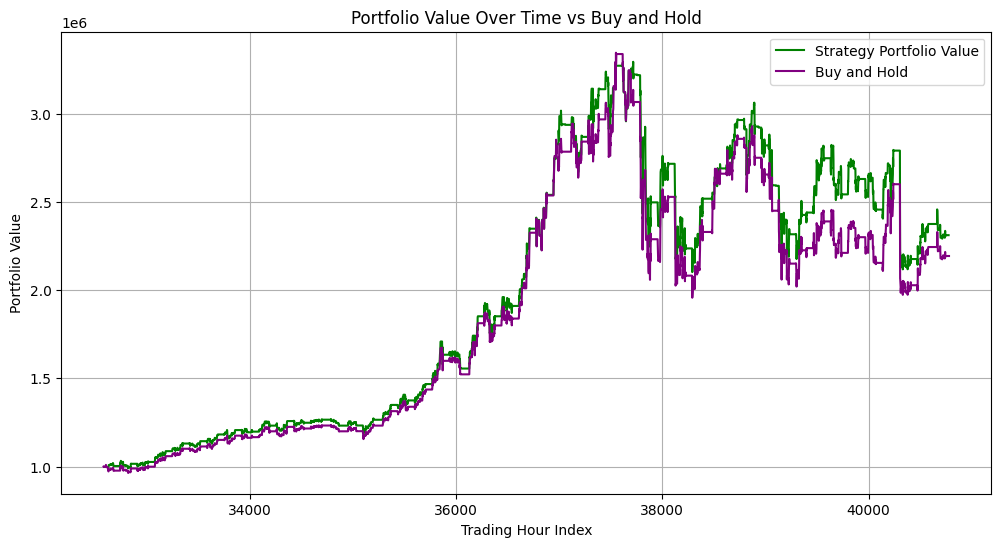

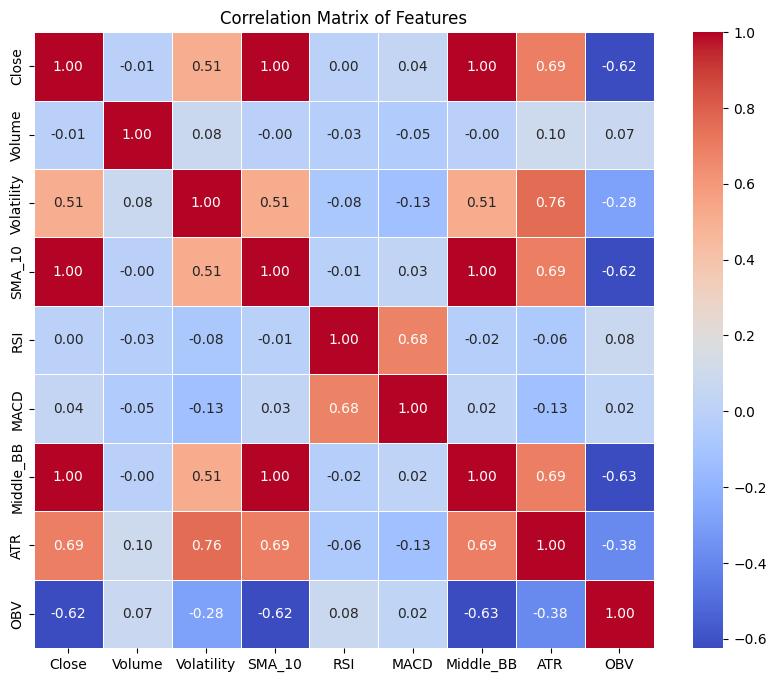

255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Performance Report:
Total Return: 156.57%
Final Portfolio Value: $2565706.78
Maximum Drawdown: 29.20%
Number of Trades: 814
Sharpe Ratio: 2.22
Sortino Ratio: 2.81

Results Buy and Hold:
Total Return: 123.90%
Sharpe Ratio: 1.88
Sortino Ratio: 2.42


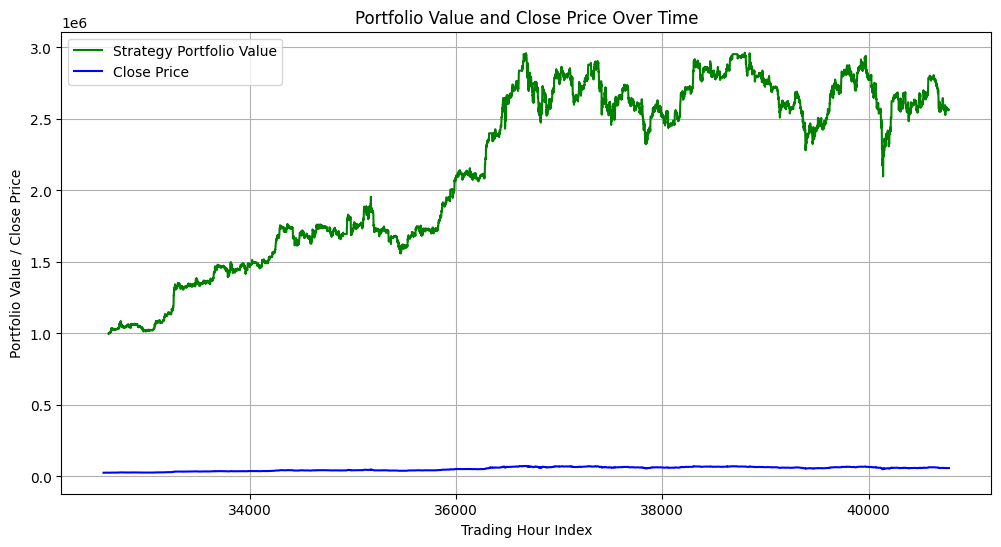

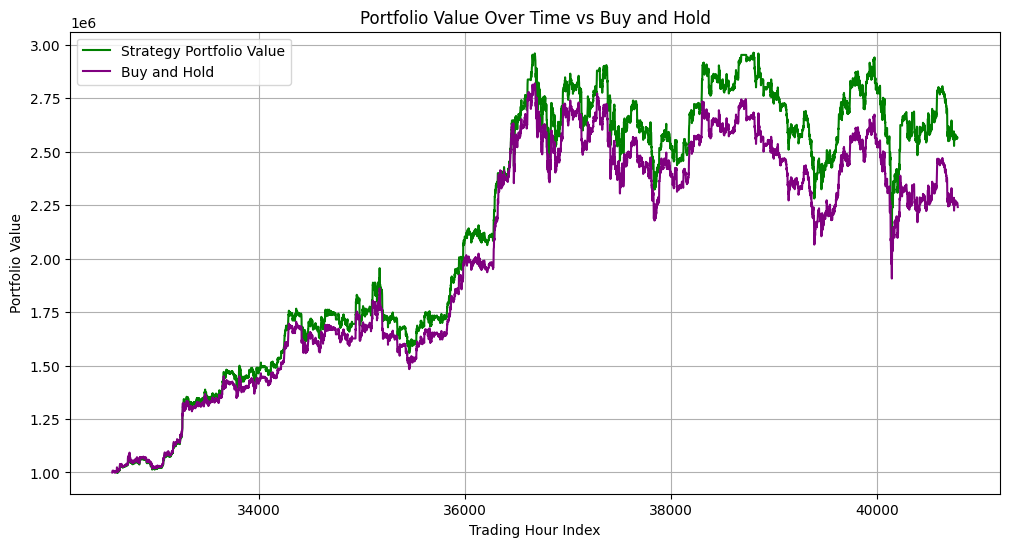

Portfolio Total Return: 144.12%
Portfolio Sharpe Ratio: 0.43


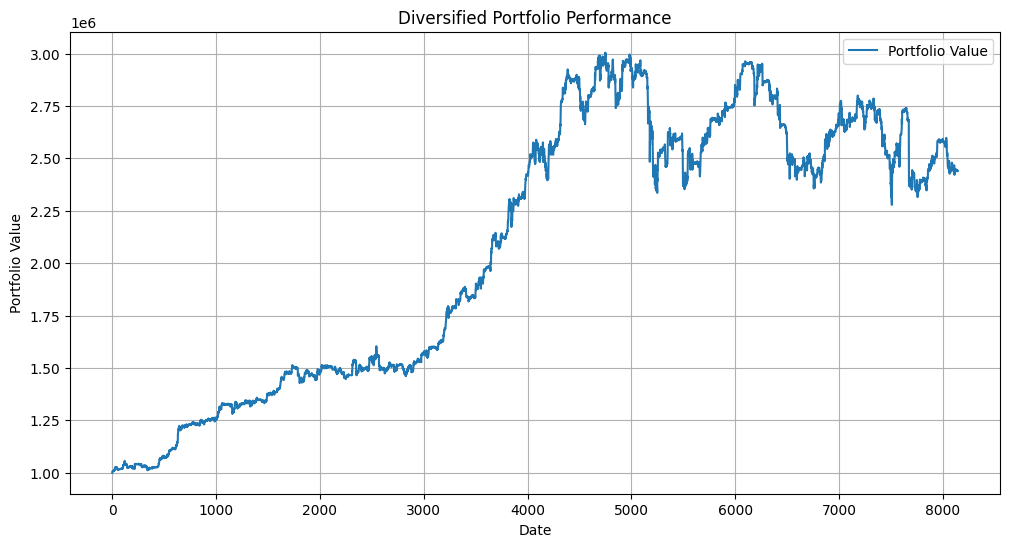

In [101]:
# Paths to data and model
csv_paths = ['/content/COCOA_TALIB.csv', '/content/BTC_TALIB.csv']
model_path = 'lstm_model_tan.keras'

# Run the pipeline and build the portfolio
results = {}
for csv_path in csv_paths:
    asset_name = csv_path.split('/')[-1].split('_')[0]
    results[asset_name] = main(csv_path)

# Assign weights to the assets (example: 40% BTC, 30% ETH, 30% COCOA)
weights = {'BTC': 0.5, 'COCOA': 0.5}

# Analyze the portfolio
portfolio = portfolio_analysis(results, weights)